# Produzindo o modelo

Agora, vamos criar e treinar o nosso modelo de fato.

Vamos pegar os dados exportados na fase de análise

Vamos pegar a MLP desenvolvida

Vamos juntar tudo e fazer um modelo que reconhece comandos sonoros.

### Ler os dados coletados
e talvez realizar algum pré-processamento

In [55]:
import pandas as pd
import os
import subprocess
import pickle

from funcoes import arquivo_mais_recente, nome_diferente
from math import inf as infinito

# ignorar warnings
import warnings
warnings.filterwarnings('ignore')

# pegar o CSV mais recente no diretório 'csv'
arquivo = arquivo_mais_recente('csv')
assert os.path.isfile(arquivo)

dataset = pd.read_csv(arquivo)

dataset

,classe,f_centro_gravidade,f_fluxo_spectral,f_media
0,2,1744.925171,0.488328,0.047517
1,2,1794.176401,3.966945,0.053057
2,2,1808.564724,10.632117,0.059772
3,2,1787.310829,5.098251,0.050345
4,2,1746.282903,4.936092,0.052391
5,2,1786.192982,1.453105,0.094307
6,2,1695.063751,1.270188,0.047092
7,2,1794.379078,0.890205,0.069452
8,2,1746.265699,3.542589,0.056585
9,2,1767.632394,0.765272,0.076983


Para saber que número pertence a que classe:

In [39]:
raiz = 'dataset'

classes = os.listdir(raiz)

for i,classe in enumerate(classes):
    print("%d: %s" % (i, classe))

0: assobio_agudo
1: assobio_grave
2: palmas
3: ruido_sedis


### Dividindo os dados coletados em conjunto de treino e teste balanceados

In [40]:
# Que porcentagem dos dados vamos pegar para treino
fracao_treino = 0.7

dados_treino = pd.DataFrame()
dados_teste = pd.DataFrame()

for classe in dataset['classe'].unique():
    # só pegar dados dessa classe
    dados = dataset.loc[dataset['classe'] == classe]
    
    treino = dados.sample(frac=fracao_treino)
    teste = dados.drop(treino.index)
    
    dados_treino = dados_treino.append(treino)
    dados_teste = dados_teste.append(teste)


###  Normalizando e dividindo em features e target

In [41]:
"""
Treino
"""
# Pegando as respostas
labels_treino = dados_treino['classe'].as_matrix()

treino_media = dados_treino.loc[:, dados_treino.columns != 'classe'].mean()
treino_desvio_padrao = dados_treino.loc[:, dados_treino.columns != 'classe'].std()
# Fazendo standardization: subtrai a média e divide pelo desvio padrão
dados_treino = (dados_treino - dados_treino.mean()) / dados_treino.std()
# Remove a coluna 'classe' e transforma em matriz
dados_treino = dados_treino.loc[:, dados_treino.columns != 'classe'].as_matrix()

"""
Teste
"""
# Pegando as respostas
labels_teste = dados_teste['classe'].as_matrix()
# Fazendo standardization: subtrai a média e divide pelo desvio padrão
dados_teste = (dados_teste - dados_teste.mean()) / dados_teste.std()
# Remove a coluna 'classe' e transforma em matriz
dados_teste = dados_teste.loc[:, dados_teste.columns != 'classe'].as_matrix()

dados_treino

array([[ 8.03930970e-01, -5.70558686e-01, -7.94286137e-01],
       [ 9.92459291e-01, -5.67110286e-01, -8.31712558e-01],
       [ 1.09012353e+00, -4.49429181e-01, -6.59201821e-01],
       [ 8.03851918e-01, -6.00192392e-01, -7.17534283e-01],
       [ 1.02400743e+00, -5.91168199e-01, -7.82089259e-01],
       [ 5.68572726e-01, -6.48516409e-01, -8.91256033e-01],
       [ 1.02493876e+00, -6.56596974e-01, -4.82044534e-01],
       [-6.59028439e-01, -6.68169354e-01, -1.85257157e-01],
       [-6.64034175e-01, -6.58370078e-01, -1.70050341e-02],
       [-1.94927014e+00, -6.21878422e-01,  2.24932335e-01],
       [-8.52092523e-01, -6.39474032e-01,  6.21725731e-01],
       [-1.59766566e+00, -5.64865748e-01,  7.11507902e-01],
       [-1.48568046e+00, -6.41780146e-01, -1.04569266e+00],
       [-1.51935252e+00, -6.39769024e-01, -9.79386335e-01],
       [ 8.81108304e-01,  1.55962351e+00,  3.39015477e+00],
       [-2.73449104e-02,  1.06531188e+00,  5.00847443e-01],
       [ 5.70839997e-01, -3.60896707e-01

### Configurando o modelo

In [42]:
# quantidade de neurônios na camada de entrada
tam_entrada = len(dados_treino[0])

# quantidade de neurônios na camada de saída
tam_saida = len(set(labels_treino))

# Quantos neurônios tem em cada camada (sem contar o bias)
formato_rede = [tam_entrada, tam_saida, tam_saida]

# Variação mínima do erro como critério de parada
delta_erro_minimo = 0.00001

# Número máximo de iterações
max_iteracoes = 10000

In [43]:
# atualizando o código dentro de MLP.py, que é extraído de MLP.ipynb
subprocess.Popen(['ipython', 'nbconvert', '--to=python', 'MLP.ipynb'])

from MLP import *

### Treinamento

In [44]:
rede = gerar_rede(formato_rede)

erro_anterior = infinito

for _ in range(max_iteracoes):
    erros = []

    for dado in range(len(dados_treino)):
        # Atualizar os pesos: joga dados[dado] na entrada, e propaga o erro
        # pra ajustar os pesos
        rede = forward_backward(rede, dados_treino[dado], one_hot(labels_treino[dado], tam_saida))

        # com os novos pesos, vamos ver o que ele prediz
        I, Y = forward(rede, dados_treino[dado])
        d = one_hot(labels_treino[dado], tam_saida)

        # vamos guardar o erro entre o que ele previu e o que é pra ser
        erros.append(erro_total(Y[-1], d))

    # erro médio
    erro = sum(erros)/len(erros)
    
    if _ == 0:
        print("erro inicial: ", erro)
        
    if _ % (max_iteracoes / 10) == 0:
        print("erro medio: ", erro)
        
    if abs(erro - erro_anterior) <= delta_erro_minimo:
        break
        
    erro_anterior = erro
        
print("\nerro final: ",erro)

erro inicial:  0.6332132675618725
erro medio:  0.6332132675618725

erro final:  0.0016611090185609783


### Testes

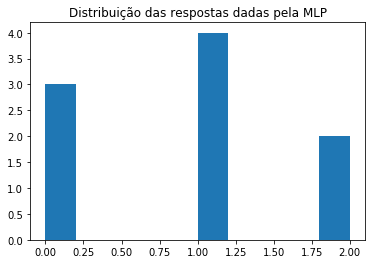

Acertou 88.9 %


In [53]:
certos = 0
errados = 0

erros = []

resultados = []

for i in range(len(dados_teste)):
    # vamos ver o que ele prediz
    resultado = predizer(rede, dados_teste[i])
    resultados.append(resultado)
    if resultado == labels_teste[i]:
        certos +=1
    else:
        errados +=1
        erros.append([dados_teste[i], classes[resultado], classes[labels_teste[i]]])

plt.hist(resultados)
plt.title("Distribuição das respostas dadas pela MLP")
plt.show()

print("Acertou %.1f %%" % (100*certos / (certos + errados)))



In [54]:
erros

[[array([ 1.03512217, -0.61579053,  0.34348645]), 'assobio_grave', 'palmas']]

In [48]:
from scipy.io import wavfile
from extratores import *

# deixar os extratores na ordem certa
copia = extratores[:]
for i,feature in enumerate(treino_desvio_padrao.index):
    busca = [f for f in copia if f.__name__ == feature]
    extratores[i] = busca[0]

teste = "teste/teste-1.wav"
taxa_amostragem, dados = wavfile.read(teste)

# Aplicar os extratores de features
dado = [f(dados) for f in extratores]

# Normalizar para aquelas features
for i in range(len(dado)):
    dado[i] = (dado[i] - treino_media[i]) / treino_desvio_padrao[i]
    
resultado = predizer(rede, dado)
classes[resultado]

'palmas'

### Exportação do modelo para arquivo

Basta serializar a variável "rede" e gravar num arquivo.

In [37]:
# estas são as variáveis que vamos guardar num arquivo.
bundle = {
    "rede": rede,
    "treino_media": treino_media,
    "treino_desvio_padrao": treino_desvio_padrao,
    "classes": classes
}

diretorio = "rede"

if not os.path.exists(diretorio):
    os.makedirs(diretorio)
    
nome = nome_diferente("rede",diretorio, formato="pickle")

with open(nome, 'wb') as myf:
    myf.write(pickle.dumps(bundle))

In [25]:
treino_desvio_padrao.index/

SyntaxError: invalid syntax (<ipython-input-25-45305c017861>, line 1)

In [26]:
a = [1,2]
b = a

In [19]:
import os
import pickle
import queue
import pyaudio
import pandas as pd
import threading
import logging
import time
import matplotlib.pyplot as plt


from funcoes import arquivo_mais_recente, get_fft_values
from MLP import predizer
from extratores import *

"""
SETUP
"""

raiz_pesos = 'rede'
raiz_audios = 'dataset'

# Carregando pesos
with open(arquivo_mais_recente(raiz_pesos), 'rb') as myf:
    bundle = pickle.load(myf)

rede = bundle['rede']
treino_media = bundle['treino_media']
treino_desvio_padrao = bundle['treino_desvio_padrao']

# Nomes das classes
classes = os.listdir(raiz_audios)

# Configurações da leitura de áudio
janela_tempo_segundos = 2
taxa_amostragem = 8000
bloco_amostras = 1000

# variáveis globais
fila = queue.Queue()
audiodata = np.zeros(janela_tempo_segundos * taxa_amostragem)
threads_ligadas = True

p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=taxa_amostragem, input=True, frames_per_buffer=bloco_amostras)

# threads

def coletar_audio():
    global fila
    global stream
    global controle_threads
    
    while threads_ligadas:
        data = stream.read(bloco_amostras)
        fila.put(np.frombuffer(data, dtype=np.int16))
    
def atualizar_buffer():
    global audiodata
    global fila
    while threads_ligadas:
        while True:
            try:
                data = fila.get_nowait()
            except queue.Empty:
                break

            audiodata = np.roll(audiodata, -bloco_amostras)
            audiodata[-bloco_amostras:] = data
        

coleta = threading.Thread(target=coletar_audio)

atualizacao_buffer = threading.Thread(target=atualizar_buffer)

In [13]:
coleta.start()
atualizacao_buffer.start()

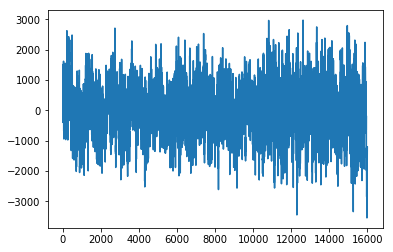

In [25]:
plt.plot(audiodata)

In [22]:
dados = audiodata.copy()

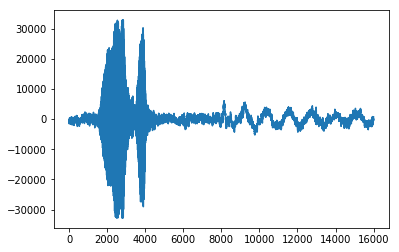

In [26]:
plt.plot(dados)

In [20]:
extratores

[<function extratores.f_media(dados)>,
 <function extratores.f_centro_gravidade(dados)>,
 <function extratores.f_fluxo_spectral(dados)>]

In [ ]:
dado = [f(dados) for f in extratores]
dado